In [1]:
!pip install -qqq ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

import os

os.chdir("../..")

In [2]:
def plot_figure(data, x, y, filename, figsize=(24, 9), log_scale=False):   
    sns.set(font_scale=1.5)
    plt.style.use("seaborn-poster")

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    g = sns.barplot(x=x, y=y, hue="Method", data=data, errwidth=2, ax=ax, palette=colors)
    if log_scale:
        g.set_yscale("log")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.savefig(f"bandits/figures/{filename}.png")
    plt.show()

## Time and Reward Figures

### MNIST

In [3]:
def read_data(dataset_name):
    df = pd.read_csv(f"bandits/results/{dataset_name}_results.csv")
    if dataset_name=="mnist":
        linear_df = df[(df["Method"]=="Lin-KF") | (df["Method"]=="Lin")].copy()
        linear_df["Model"] = "MLP2"
        df = df.append(linear_df)
        linear_df["Model"] = "LeNet5"
        df = df.append(linear_df)

    by = ["Rank"] if dataset_name=="tabular" else ["Rank", "AltRank"]

    data_up = df.sort_values(by=by).copy()
    data_down = df.sort_values(by=by).copy()

    data_up["Reward"] = data_up["Reward"] + data_up["Std"]
    data_down["Reward"] = data_down["Reward"] - data_down["Std"]
    data = pd.concat([data_up, data_down])
    return data

In [4]:
method_ordering = {"EKF-Sub-SVD": 0,
                   "EKF-Sub-RND": 1,
                   "EKF-Sub-Diag-SVD": 2,
                   "EKF-Sub-Diag-RND": 3,
                   "EKF-Orig-Full": 4,
                   "EKF-Orig-Diag": 5,
                   "NL-Lim": 6,
                   "NL-Unlim": 7,
                   "Lin": 8,
                   "Lin-KF": 9,
                   "Lin-Wide": 9,
                   "Lim2": 10,
                   "NeuralTS": 11}
                   
colors = {k : sns.color_palette("Paired")[v] if k!="Lin-KF" else  sns.color_palette("tab20")[8] for k,v in method_ordering.items()}

In [5]:
mnist_checkboxes = []
ignored = ["Lim2", "Lin-Wide", "EKF-Orig-Full", "NeuralTS"]

for description in method_ordering.keys():
    if description in ignored:
        continue
    value = False if description=="Lin-KF" else True
    checkbox = widgets.Checkbox(description=description, value=value)
    mnist_checkboxes.append(checkbox)

mnist_menu = widgets.VBox(mnist_checkboxes)
mnist_menu

In [6]:
dataset_name = "mnist"
mnist_rows = [child.description for child in mnist_menu.children if child.value]

In [7]:
mnist_df = read_data(dataset_name)
mnist_df = mnist_df[mnist_df['Method'].isin(mnist_rows)]

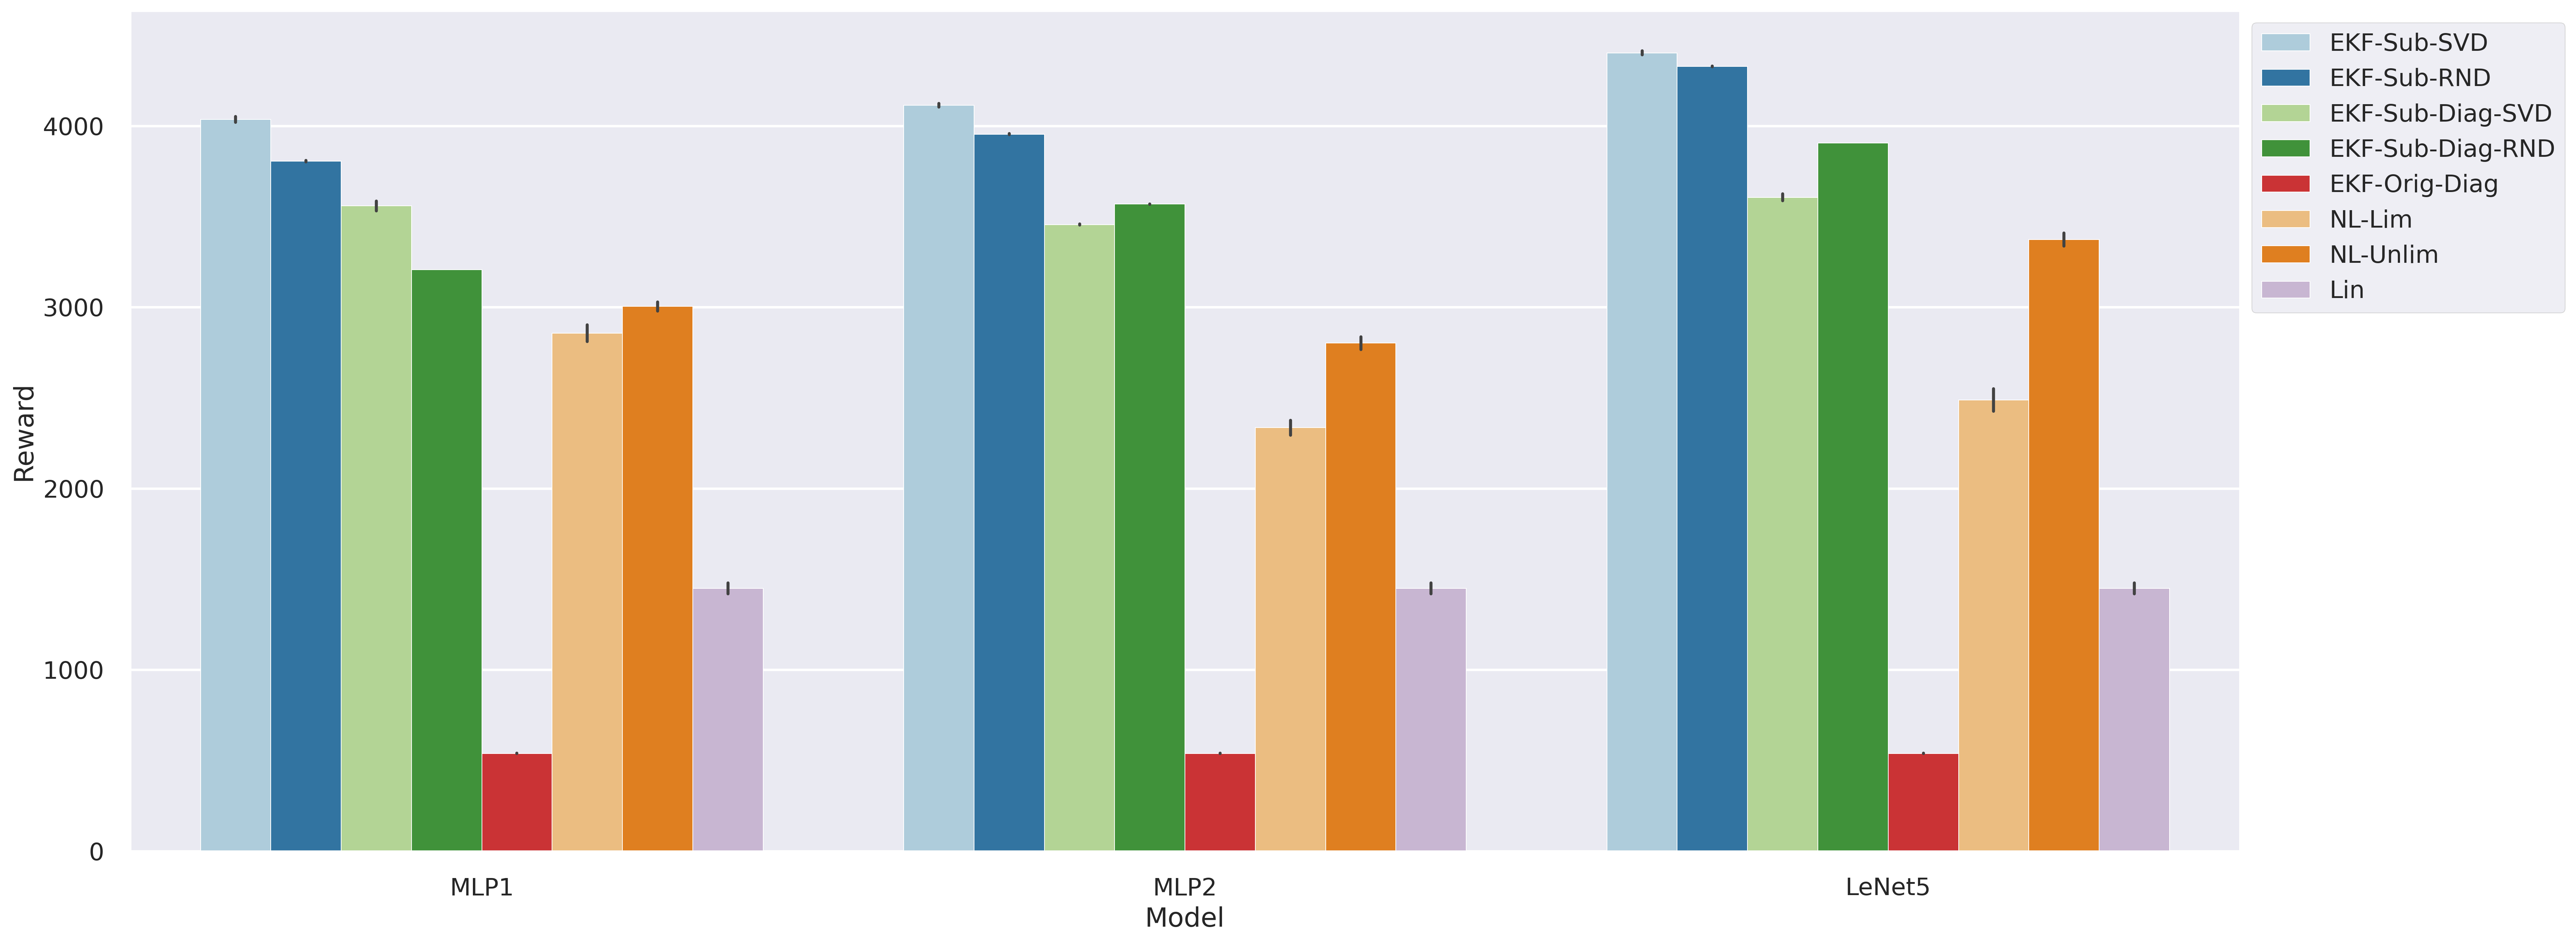

In [8]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(mnist_df, x, y, filename)

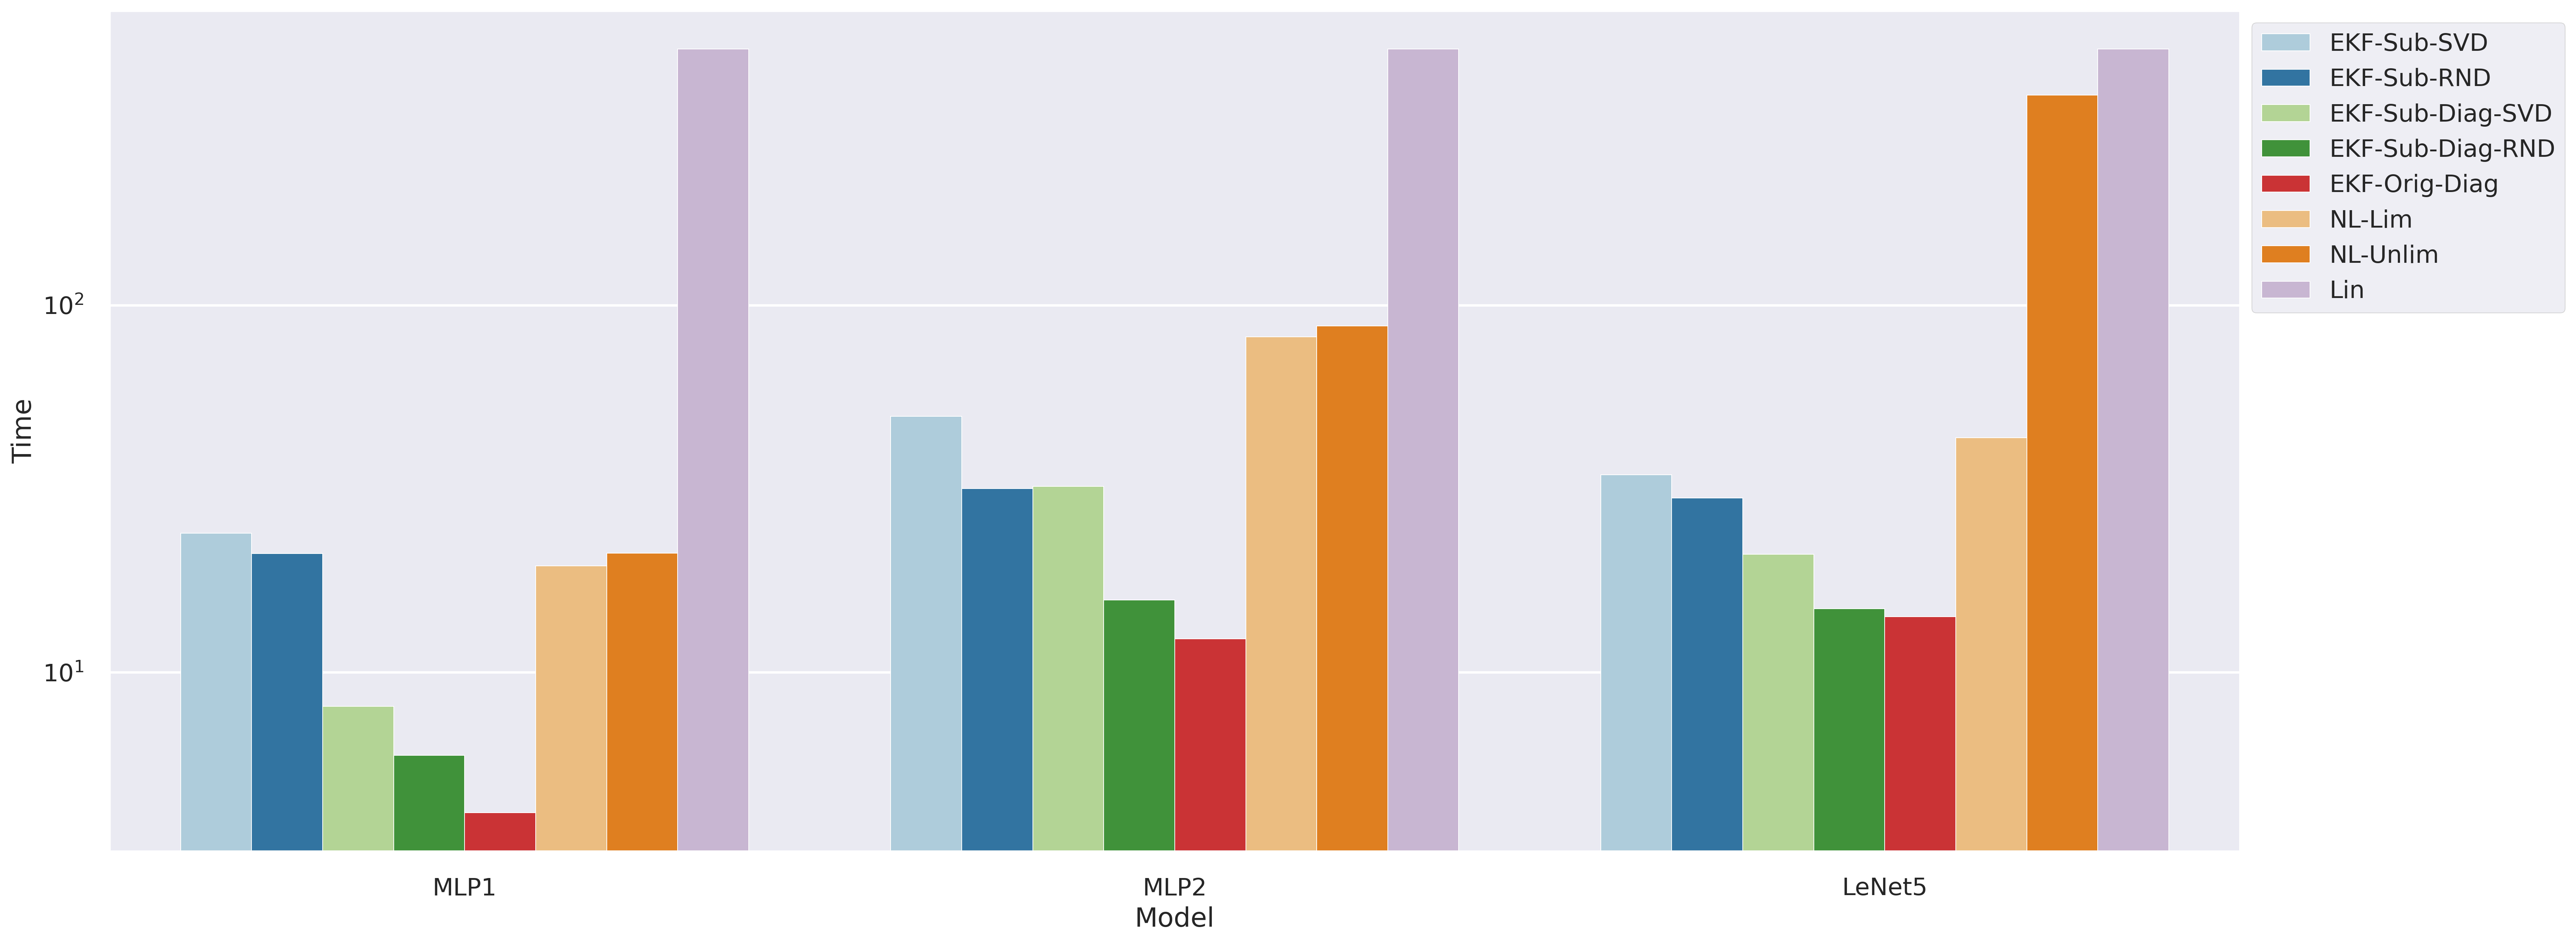

In [9]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(mnist_df, x, y, filename, log_scale=True)

### Tabular

In [10]:
tabular_checkboxes = []

for description in method_ordering.keys():
    value = False if description=="Lin-KF" or description=="Lin-Wide" else True
    checkbox = widgets.Checkbox(description=description, value=value)
    tabular_checkboxes.append(checkbox)

tabular_menu = widgets.VBox(tabular_checkboxes)
tabular_menu

In [11]:
dataset_name = "tabular"
tabular_df = read_data(dataset_name)
tabular_rows = [child.description for child in tabular_menu.children if child.value]
tabular_df = tabular_df[tabular_df['Method'].isin(tabular_rows)]

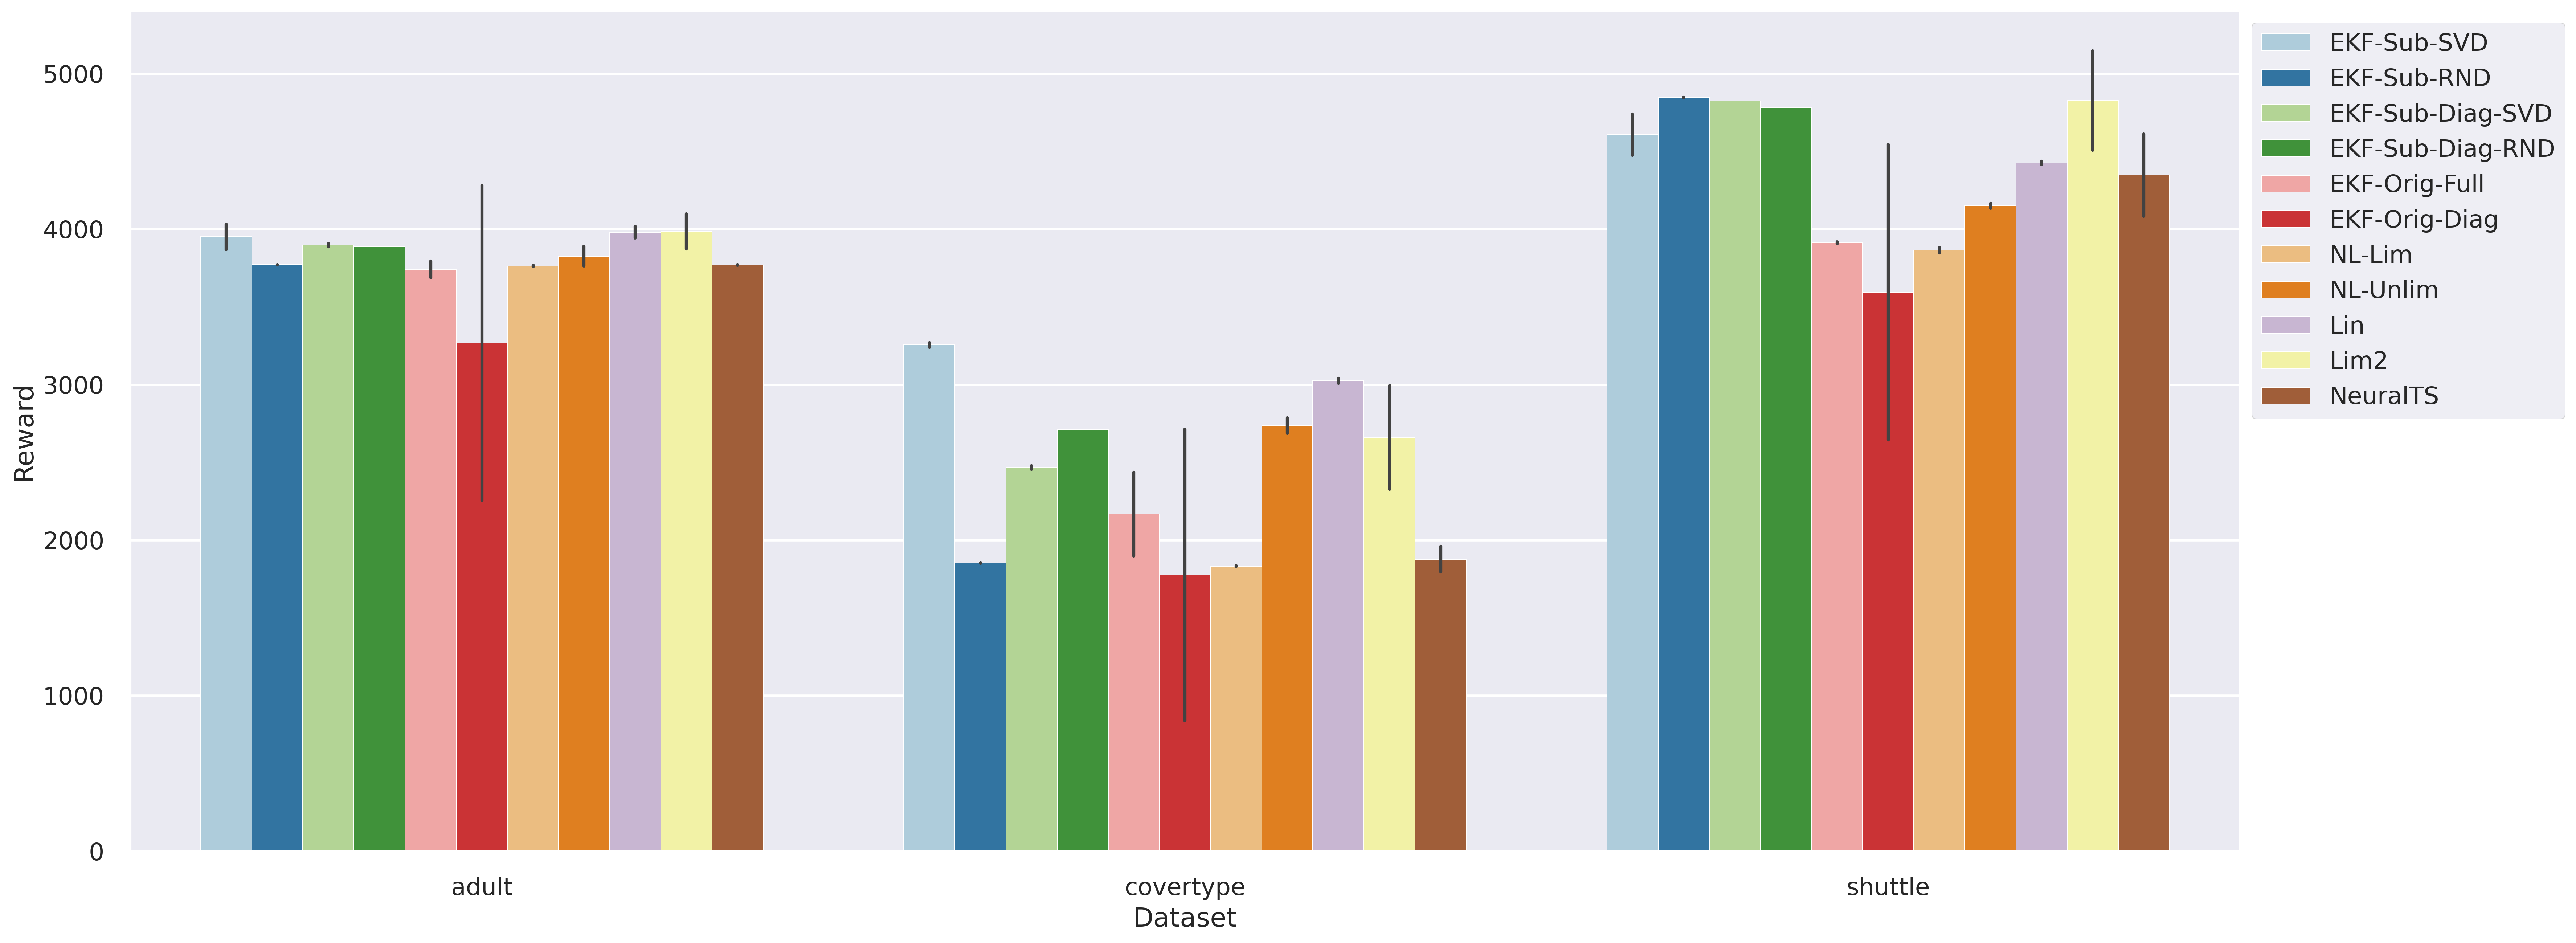

In [12]:
x, y = "Dataset", "Reward"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(tabular_df, x, y, filename)

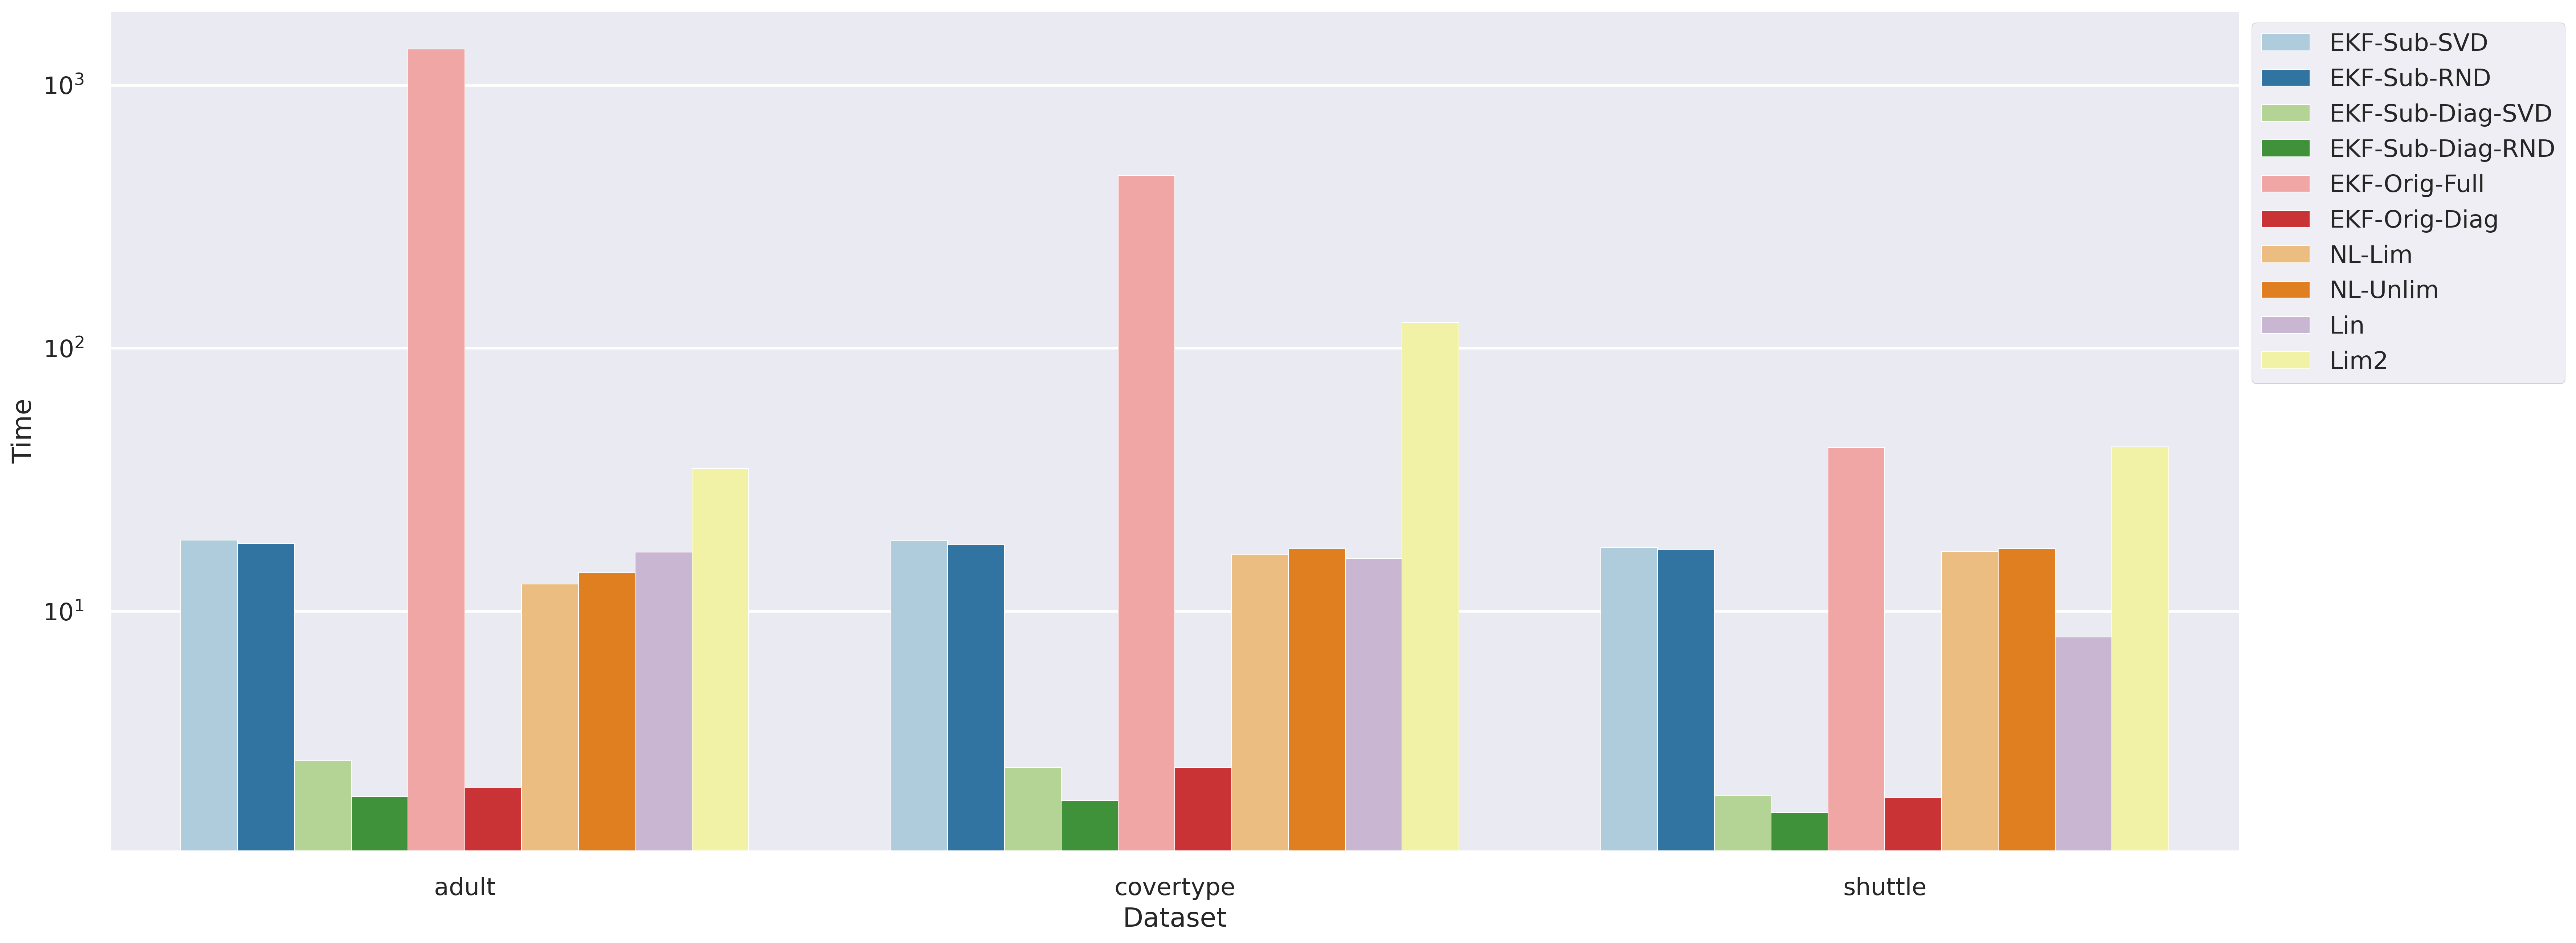

In [13]:
x, y = "Dataset", "Time"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(tabular_df[tabular_df["Method"] != "NeuralTS"], x, y, filename, log_scale=True)

### Movielens

In [14]:
movielens_checkboxes = []

for description in method_ordering.keys():
    if description in ignored:
        continue
    value = False if description=="Lin-KF" else True
    checkbox = widgets.Checkbox(description=description, value=value)
    movielens_checkboxes.append(checkbox)

movielens_menu = widgets.VBox(movielens_checkboxes)

In [15]:
dataset_name = "movielens"
movielens_df = read_data(dataset_name)
movielens_rows = [child.description for child in movielens_menu.children if child.value]
movielens_df = movielens_df[movielens_df['Method'].isin(movielens_rows)]

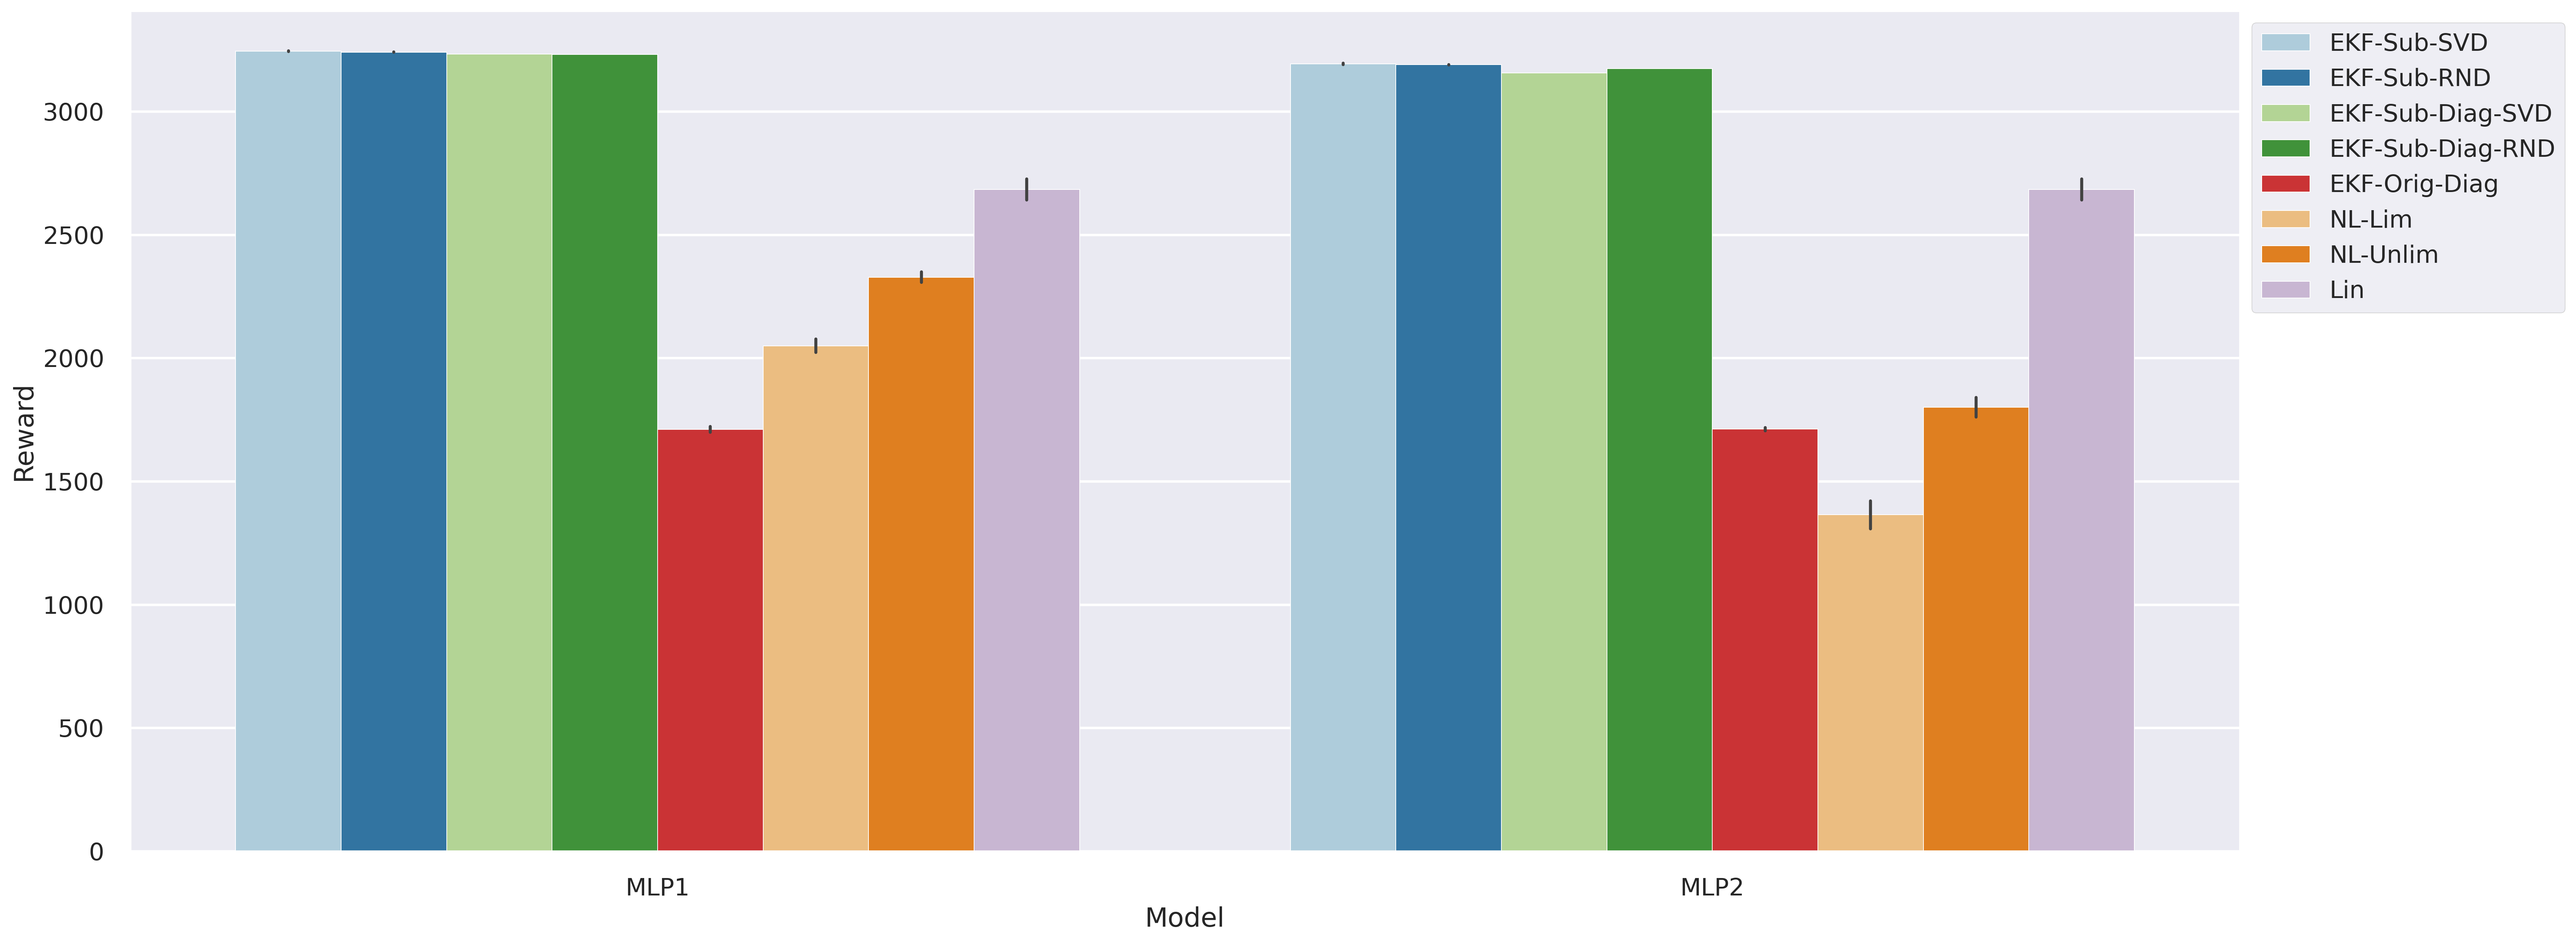

In [16]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(movielens_df, x, y, filename)

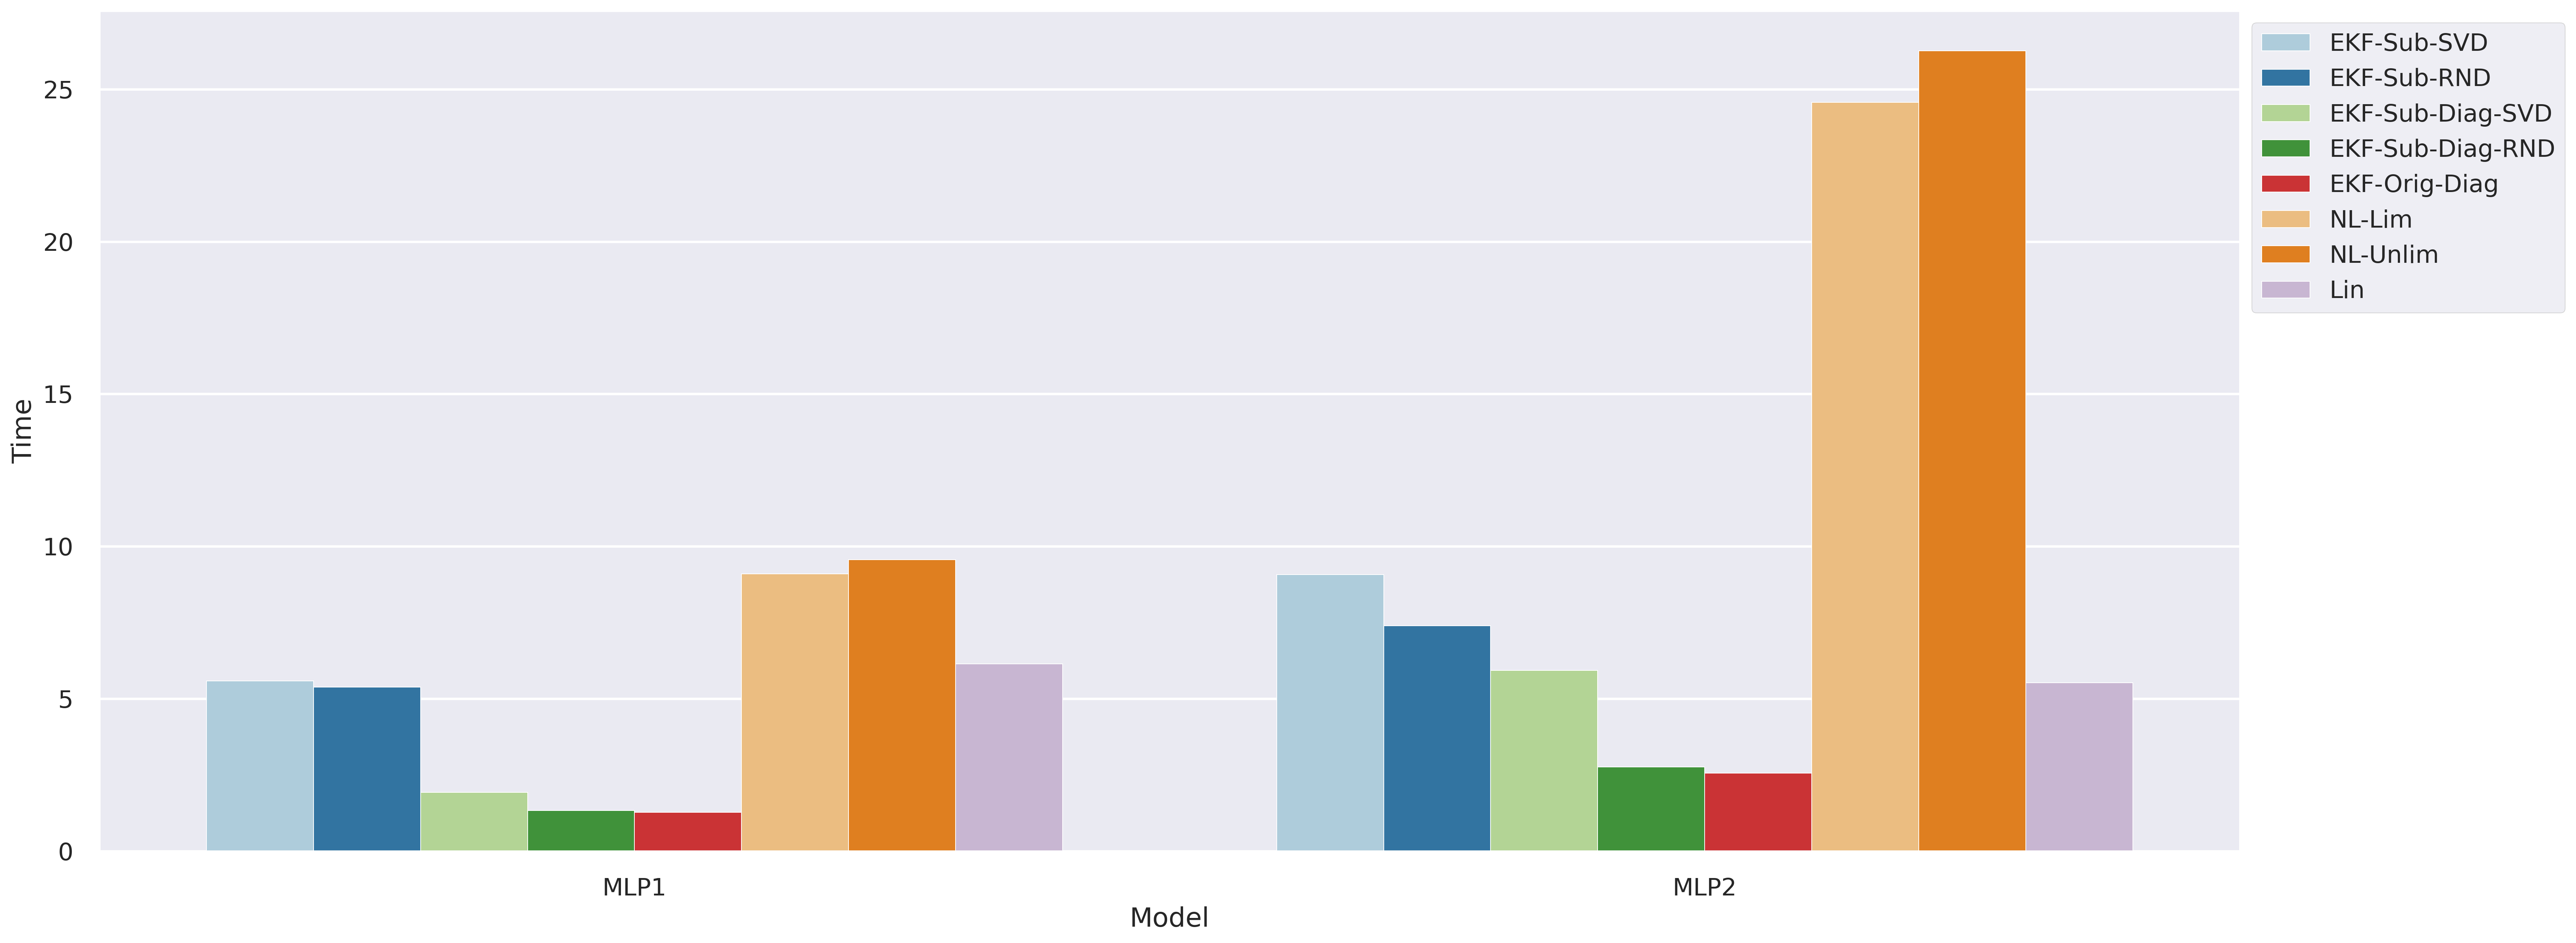

In [17]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(movielens_df, x, y, filename)

## Subspace Dim vs. Reward Figures

In [18]:
def plot_subspace_figure(df, filename=None):
  df = df.reset_index().drop(columns=["index"])
  plt.style.use("seaborn-darkgrid")
  fig, ax = plt.subplots(figsize=(12, 8))
  sns.lineplot(x="Subspace Dim", y="Reward", hue="Method", marker="o", data=df)
  lines, labels = ax.get_legend_handles_labels()
  for line, method in zip(lines, labels):
    data = df[df["Method"]==method]
    color = line.get_c()
    ax.fill_between(data["Subspace Dim"],  data["Reward"] -  data["Std"],  data["Reward"] + data["Std"], color=color, alpha=0.3)
   
  ax.set_ylabel("Reward", fontsize=16)
  plt.setp(ax.get_xticklabels(), fontsize=16) 
  plt.setp(ax.get_yticklabels(), fontsize=16) 
  ax.set_xlabel("Subspace Dimension(d)", fontsize=16)
  dataset = df.iloc[0]["Dataset"]
  ax.set_title(f"{dataset.title()} - Subspace Dim vs. Reward", fontsize=18)
  legend = ax.legend(loc="lower right", prop={'size': 16},frameon=1)
  frame = legend.get_frame()
  frame.set_color('white')
  frame.set_alpha(0.6)
  if filename is None:
    plt.savefig(f"bandits/figures/{dataset}_sub_reward.png")
  else:
    plt.savefig(f"bandits/figures/{filename}.png")
  plt.show()

In [19]:
tabular_sub_df = pd.read_csv("bandits/results/tabular_subspace_results.csv")

## Shuttle

In [20]:
dataset_name = "shuttle"
shuttle = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]

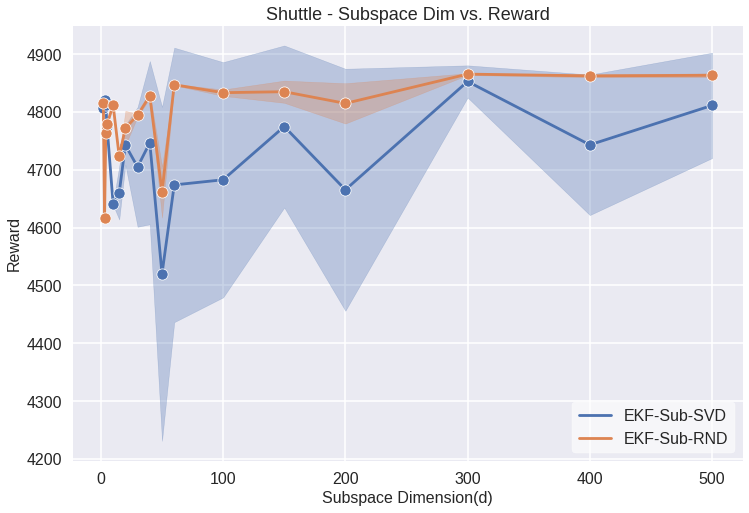

In [21]:
plot_subspace_figure(shuttle)

### Adult

In [22]:
dataset_name = "adult"
adult = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]

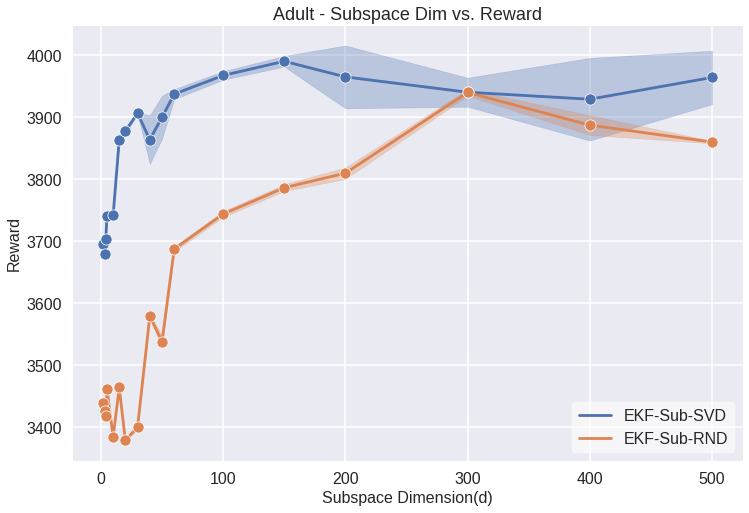

In [23]:
plot_subspace_figure(adult)

### Covertype

In [24]:
dataset_name = "covertype"
covertype = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]

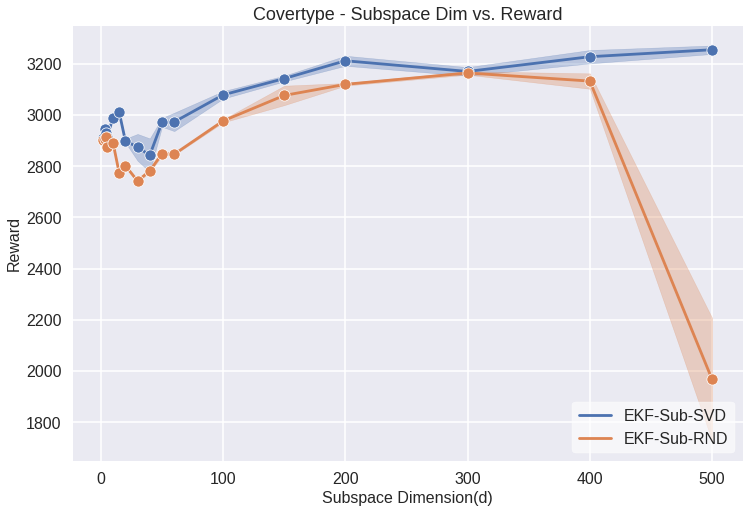

In [25]:
plot_subspace_figure(covertype)